# Building a state of the art bacterial classifier with fastai

> ***This is a modified version of the notebook [Bacteria Classification with fast.ai](https://ml-showcase.paperspace.com/projects/bacteria-classification-fast-ai-dibas) created by The Gradient Team at Paperspace***. 

> The code has been slightly updated to support the most recent fastai version and some additional content added. 

The fast.ai library has been breaking records as students use it to produce state of the art results on a myriad of tasks. Some examples given in the course include environmental sound classification and handwritten devanagari prediction.

In this notebook we'll use the library for state of the art bacteria classification with the [DIBaS (Digital Image of Bacterial Species) dataset](http://misztal.edu.pl/software/databases/dibas/). See also _Zieliński, Bartosz, et al. ["Deep learning approach to bacterial colony classification."](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0184554) PloS one 12.9 (2017)_ paper link]. DIBaS contains 660 images, with 33 different genera and species of bacteria.

You can also check out the full blog post on [Building a Bacterial Classifier with fast.ai](https://blog.paperspace.com/building-a-state-of-the-art-bacterial-classifier-with-paperspace-gradient-and-fast-ai/) by Harsh Sikka.

## Install and load libraries

In [ ]:
!pip install -Uqq fastbook
!pip install bs4

In [ ]:
import os
import requests
import shutil
import zipfile
import matplotlib.pyplot as plt

import fastbook
fastbook.setup_book()
from fastbook import *

from fastai.vision.all import *
from bs4 import BeautifulSoup

# Download and load bacteria dataset

In [ ]:
if not os.path.exists('./storage/dibas_zips'):
    os.makedirs('./storage/dibas_zips')

if not os.path.exists('./storage/dibas_images'):
    os.makedirs('./storage/dibas_images')

In [ ]:
if not os.path.exists('./storage/dibas_zips/Acinetobacter.baumanii.zip'):
    # Parse the webpage; images are saved in a separate .zip file for each strain of bacteria
    url = 'http://misztal.edu.pl/software/databases/dibas/'
    response = requests.get(url)
    soup = BeautifulSoup(response.text, "html.parser")

    links = [tag['href'] for tag in soup.findAll('a')]

    for link in links:
        if ".zip" in link:
            file_name = link.partition("/dibas/")[2]
            urllib.request.urlretrieve(link, './storage/dibas_zips/' + file_name) 
            zip_ref = zipfile.ZipFile('./storage/dibas_zips/' + file_name, 'r')
            zip_ref.extractall('./storage/dibas_images/')   
            zip_ref.close()
            print("Downloaded and extracted: " + file_name)

In [ ]:
path = Path('./storage/dibas_images/')
path.ls()

(#670) [Path('storage/dibas_images/Veionella_0013.tif'),Path('storage/dibas_images/Lactobacillus.paracasei_0020.tif'),Path('storage/dibas_images/Propionibacterium.acnes_0018.tif'),Path('storage/dibas_images/Lactobacillus.plantarum_0020.tif'),Path('storage/dibas_images/Lactobacillus.jehnsenii_0017.tif'),Path('storage/dibas_images/Neisseria.gonorrhoeae_0001.tif'),Path('storage/dibas_images/Listeria.monocytogenes_0013.tif'),Path('storage/dibas_images/Lactobacillus.salivarius_0017.tif'),Path('storage/dibas_images/Escherichia.coli_0011.tif'),Path('storage/dibas_images/Porfyromonas.gingivalis_0001.tif')...]

### Check the images and delete the ones that won't load

In [ ]:
failed = verify_images(path.ls(file_exts='.tif'))

In [ ]:
failed

(#1) [Path('storage/dibas_images/Listeria.monocytogenes_0023.tif')]

Delete the ones that didn't load:

In [ ]:
failed.map(Path.unlink)

(#0) []

# Create dataloaders

In [ ]:
def label_func(fn):
    return str(fn.name).split('_')[0]

In [ ]:
item_tfms = Resize(400, method='pad')

In [ ]:
batch_tfms = [Resize(300, method='pad'), Flip(), Zoom(),
              Contrast(), Rotate(30), Normalize.from_stats(*imagenet_stats)]

In [ ]:
db = DataBlock(blocks=[ImageBlock(), CategoryBlock()], 
                get_items= partial(get_image_files, recurse=False),
                get_y = label_func,
                splitter=RandomSplitter(valid_pct=0.3),
                item_tfms=item_tfms,
                batch_tfms=batch_tfms
              )

In [ ]:
dls = db.dataloaders(path, bs=64)

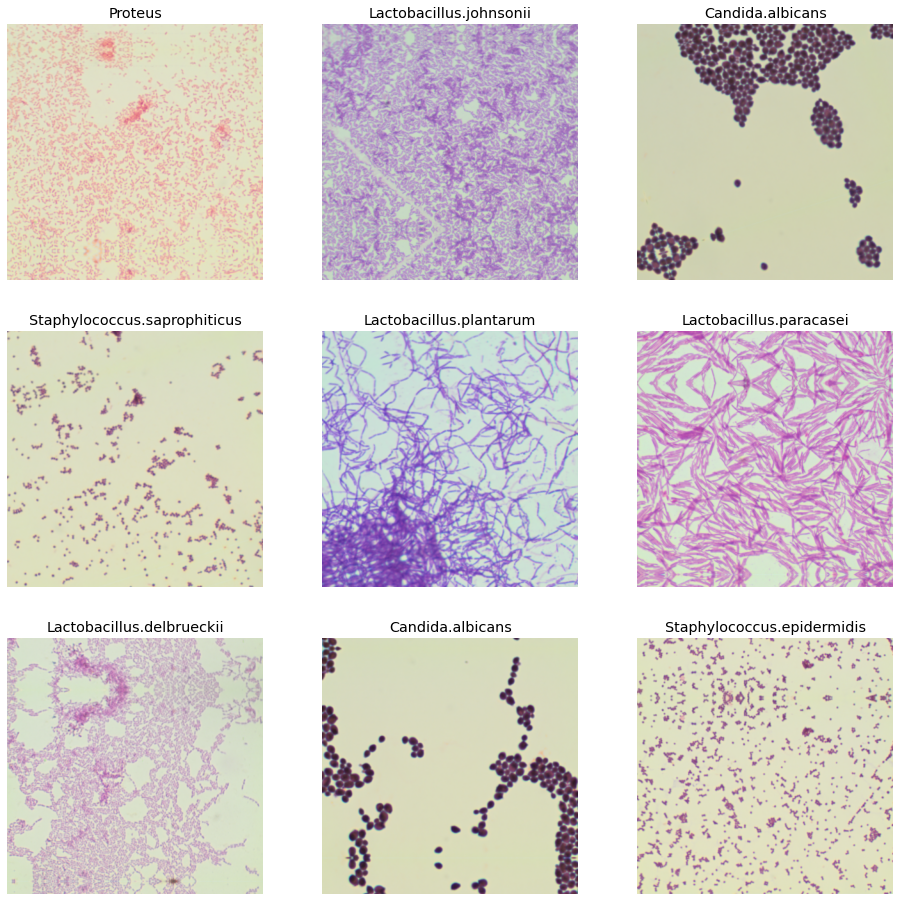

In [ ]:
dls.show_batch(figsize=(16,16))

# Train models

In [ ]:
learn = cnn_learner(dls, resnet34, metrics=[accuracy, error_rate])

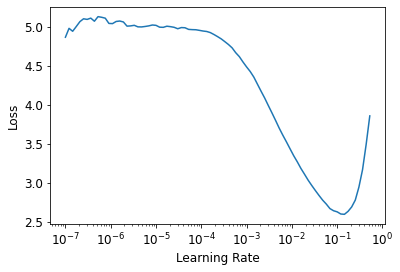

In [ ]:
lr_min, lr_steep = learn.lr_find(suggestions=True)

In [ ]:
lr_min, lr_steep

(0.014454397559165954, 0.004365158267319202)

In [ ]:
learn.fine_tune(10, base_lr=lr_min/10)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,4.747705,3.355695,0.125000,0.875000,00:24


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,2.561700,2.103155,0.405000,0.595000,00:28
1,2.108403,0.840373,0.850000,0.150000,00:28
2,1.628748,0.312546,0.925000,0.075000,00:28
3,1.280666,0.170882,0.950000,0.050000,00:28
4,1.035575,0.113341,0.980000,0.020000,00:29
5,0.851337,0.098003,0.980000,0.020000,00:28
6,0.714568,0.089973,0.980000,0.020000,00:28
7,0.610052,0.087074,0.985000,0.015000,00:28
8,0.529615,0.088181,0.985000,0.015000,00:28
9,0.462140,0.087604,0.985000,0.015000,00:28


# Evaluate results

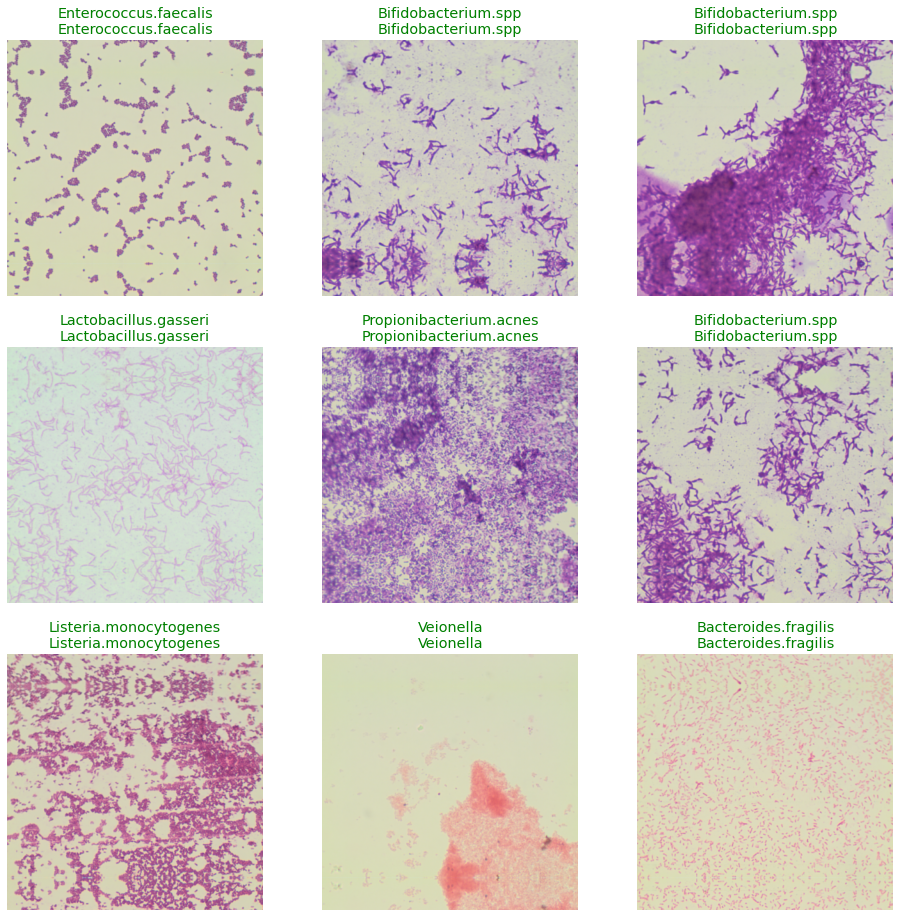

In [ ]:
learn.show_results(figsize=(16,16))

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

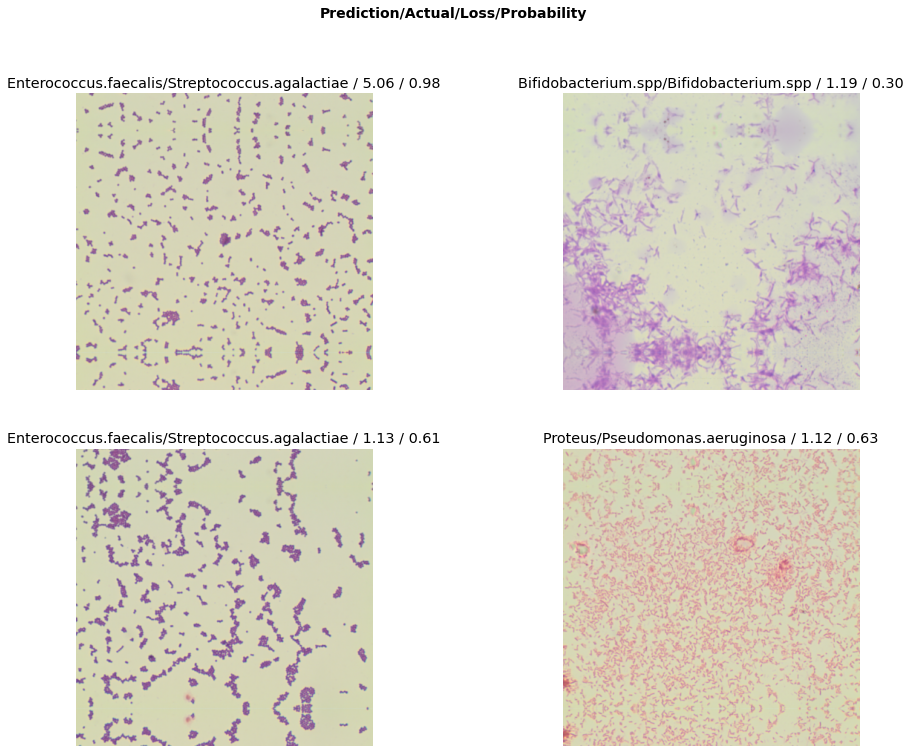

In [ ]:
interp.plot_top_losses(4, figsize=(16,12))

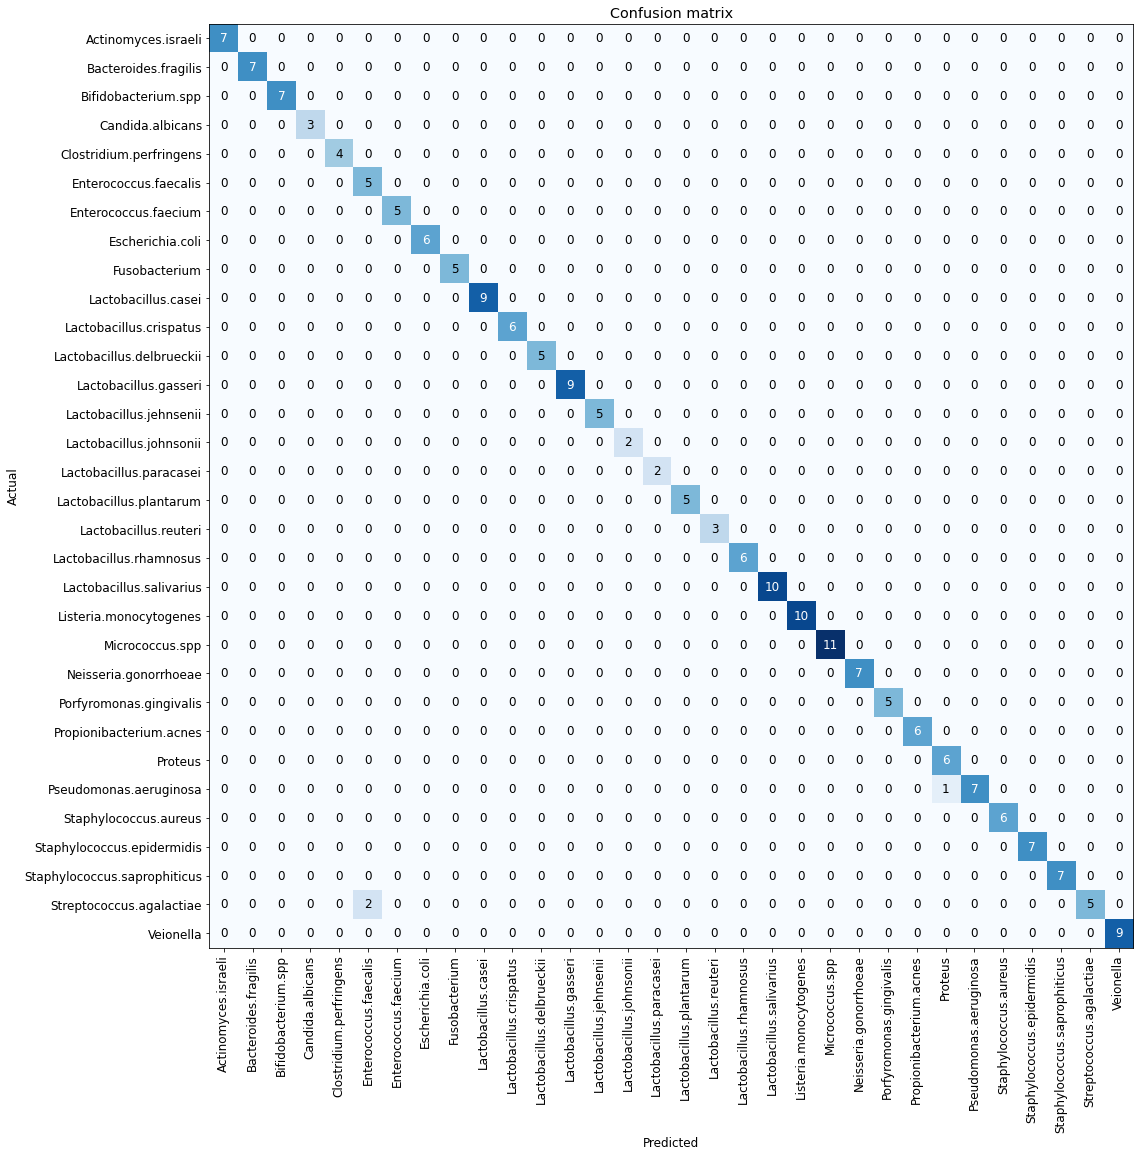

In [ ]:
interp.plot_confusion_matrix(figsize=(16,16))

In [ ]:
0.015000 * len(learn.dls.valid_ds.items)

3.0

Only three errors among the 200 images in the validation set.

# Your turn!

1. To compare with the results of the original paper one should design a more careful validatation setup. In the paper they did a 25 fold cross-validation. Try to do something similar (but with a smaller number of folds if you don't have time for 25 training runs).
2. Try other CNN network architectures.
3. Look into other data augmentation strategies.
4. Add class activation maps (CAM and/or gradCAM) to investigate what features the model used to make its classifications.